# Demo of `DroneWQ` functions and processing pipeline

In this notebook, we demonstrate the use functions included in DroneWQ package

#TODO- add more details of notebook

In [2]:
#awedits: this chunk is in here before using Docker
import os
from micasense import image as image
from micasense import imageset as imageset
from micasense import capture as capture
from micasense import image as image
from micasense import metadata as meta
from micasense import panel
import micasense.plotutils as plotutils

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import rasterio
import math

import warnings
warnings.filterwarnings('ignore')
    
exiftoolPath = None
if os.name == 'nt':
    exiftoolPath = 'F:/Micasense_WQ/exiftool/exiftool.exe'

In [1]:
# pgedits I thik all these imports and things should be tucked away in the .py script you make and then all 
# you'll need to do is import that one script

import os
from micasense import image as image
from micasense import imageset as imageset
from micasense import capture as capture
from micasense import image as image
from micasense import metadata as meta
from micasense import panel
import micasense.plotutils as plotutils

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import rasterio
import math

import warnings
warnings.filterwarnings('ignore')

# this is the location of the install of exiftool on the docker install I've created
exiftoolPath = '/usr/local/envs/micasense/bin/exiftool'

KeyboardInterrupt: 

### store_metadata

Organize metadata from MicaSense GPS and IMU of flight captures. Metadata can be used for plotting flight capture locations and georeferencing

In [3]:
def store_metadata(imagePath):
    """
    Saves metadata from each image as a Pandas DataFrame

    Parameters
    ----------
    imagePath : string
        File path of images

    Returns
    -------
    df : Pandas DataFrame
        Metadata from each individual capture
    --------
    """
    
    flight_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'flight')).captures
    print('# of flight captures =', len(flight_imgset))

    columns = ['ID', 'SourceFile', 'DateTimeStamp','Latitude' ,'Longitude',
              'Altitude','Yaw', 'Pitch', 'Roll', 'SolarElevation']
    #,FocalLength_mm,ImageWidth,ImageHeight,ImageSize_?,Resolution_mm,SensorSize_mm\n"

    data=[]
    
    for i,capture in enumerate(flight_imgset):
        ID = 'capture_' + str(i+1)
        SourceFile =  os.path.join(imagePath, ID)
        DateTimeStamp = capture.utc_time().strftime("%Y:%m:%d,%H:%M:%S,")
        Latitude = capture.location()[0]
        Longitude = capture.location()[1]
        Altitude = capture.location()[2]
        Yaw = capture.images[0].dls_yaw
        Pitch = capture.images[0].dls_pitch
        Roll = capture.images[0].dls_roll
        SolarElevation = capture.images[0].solar_elevation
        
        # aedits- need to clarify these metadata lines
        '''
        #meta = metadata.Metadata(exiftoolPath=exiftoolPath)
        #print(meta.print_all())
        #print(meta.get_item('EXIF:FocalPlaneXResolution'))
        linestr += '"{}",'.format(capture.images[0].focal_length) #FocalLength_mm
        linestr += '"{}",'.format(meta.get_item('EXIF:ImageWidth')) #ImageWidth
        linestr += '"{}",'.format(meta.get_item('EXIF:ImageHeight')) #ImageHeight
        linestr += '"{}",'.format(capture.images[0].size()) #ImageSize_? #TODO- why is this diff than EXIF image width,height?
        linestr += '"{}",'.format(capture.images[0].focal_plane_resolution_px_per_mm) #Resolution_mm #TODO- this doesn't make sense
        linestr += '"{}",'.format(meta.get_item('EXIF:ImageWidth') / capture.images[0].focal_plane_resolution_px_per_mm[0], meta.get_item('EXIF:ImageHeight') / capture.images[0].focal_plane_resolution_px_per_mm[1]) #SensorSize
        # dividing the pixel size by the focal plane resolution in mm to get sensor size - px/(px/mm) leaves mm
        '''
        row = [ID] + [SourceFile] + [DateTimeStamp] + [Latitude] + [Longitude] + [Altitude] + \
        [Yaw] + [Pitch] + [Roll] + [SolarElevation]
        data.append(row)
        
        df = pd.DataFrame.from_records(data, index='ID', columns=columns)
        df['DateTimeStamp'] = pd.to_datetime(df.DateTimeStamp,format='%Y:%m:%d,%H:%M:%S,')
    
    return(df)

In [4]:
# pgedits I think once we have pulled out the actual function blocks we can just have blocks like this that explain the functions based on the documentation we add there inline.
?store_metadata

Signature: store_metadata(imagePath)
Docstring:
Saves metadata from each image as a Pandas DataFrame

Parameters
----------
imagePath : string
    File path of images

Returns
-------
df : Pandas DataFrame
    Metadata from each individual capture
--------
File:      f:\micasense_wq\imageprocessing\final\final\<ipython-input-3-366a57808cfc>
Type:      function


This functon creates a dataframe that can be used later. We can inspect a sample of what's included:

In [6]:
metadata = store_metadata(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'))
metadata.head(5)

# of flight captures = 21


,SourceFile,DateTimeStamp,Latitude,Longitude,Altitude,Yaw,Pitch,Roll,SolarElevation
ID,,,,,,,,,
capture_1,F:/Micasense_WQ\10_01_20\0002SET\000_test\capt...,2020-10-01 16:02:25,38.696392,-75.980388,88.155,-0.139167,-0.128895,0.071403,0.805768
capture_2,F:/Micasense_WQ\10_01_20\0002SET\000_test\capt...,2020-10-01 16:02:27,38.696407,-75.980256,87.371,-0.195633,-0.138176,-0.291413,0.805786
capture_3,F:/Micasense_WQ\10_01_20\0002SET\000_test\capt...,2020-10-01 16:02:29,38.696414,-75.980192,87.063,-0.360275,-0.140909,-0.298009,0.805840
capture_4,F:/Micasense_WQ\10_01_20\0002SET\000_test\capt...,2020-10-01 16:02:31,38.696411,-75.980187,86.925,-1.401576,-0.191536,-0.377597,0.805876
capture_5,F:/Micasense_WQ\10_01_20\0002SET\000_test\capt...,2020-10-01 16:02:33,38.696399,-75.980194,86.926,-1.389996,-0.193731,0.449295,0.805912


The metadata dataframe can be saved as a .csv

In [8]:
metadata.to_csv(os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test', 'metadata.csv'))

Captures can be plotted using metadata dataframe

Text(0, 0.5, 'Latitude')

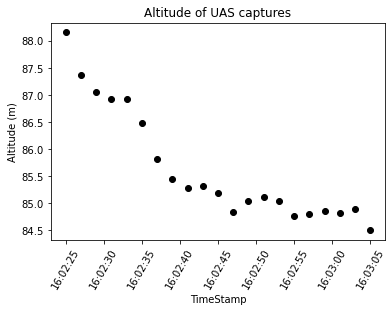

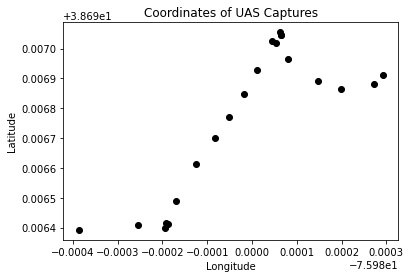

In [9]:
#plot altitude
plt.scatter(metadata['DateTimeStamp'].values, metadata['Altitude'].values, color='black')
plt.xticks(rotation=60)
plt.title("Altitude of UAS captures")
plt.xlabel("TimeStamp")
plt.ylabel("Altitude (m)")

#plot lat, lon
plt.figure(2)
plt.scatter(metadata['Longitude'].values, metadata['Latitude'].values, color='black')
plt.title("Coordinates of UAS Captures")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

### align_stack_tifs

This function creates aligned, stacked tifs of captures of different radiometric units: Digital number (DN), total radiace (Lt), sky radiance (Lsky), reflectance (Ruas), remote sensing reflectance (Rrs) 

This function applies an alignment procedure provided by MicaSense `create_aligned_capture()` that:

1) unwarps images using built-in lens calibration

2) applies transformation to align each band to a common band

3) crops pixels that don't overlap in all bands. 

It then stacks aligned bands into a single tiff using a stack export procedure `save_capture_as_stack()`. 

In [141]:
def align_stack_tifs(imagePath, image_type, out_format, outputPath, 
                     overwrite=True, generateThumbnails=True,
                     Ed_opt='DLS', panel_ref_from_serial='panel_ref_from_serial',
                     Rrs_method='black_pixel',
                     DN_path="", Lt_path="", Lsky_path="", Ruas_path="",
                     visualize=False):
    """
    applies an alignment procedure and stacks bands into a single tiff for each capture

    Parameters
    ----------
    imagePath : string
        <what is this parameter?>
    generateThumbnails : ?
        <what is this parameter?>


    Returns
    -------
    <output_name> : <output format>
        <what is this output>
    ------
    """
    
    if image_type == 'sky':
         imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'sky')).captures
    if image_type == 'flight':
        imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'flight')).captures
        
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

    #Create aligned, stacked tifs with values of DN, Lt/Lsky, Ruas, or Rrs   
    for i,capture in enumerate(imgset):
        outputFilename = out_format + '_'+ str(i+1) +'.tif' #+1 so naming starts at 1, not 0
        if (not os.path.exists(os.path.join(outputPath, outputFilename))) or overwrite:
            align = capture.create_aligned_capture(warp_matrices=None, img_type='radiance')

            if out_format == 'DN':
                stack = capture.save_capture_as_stack(os.path.join(outputPath, outputFilename), sort_by_wavelength = True)
                if generateThumbnails:
                    thumbnailFilename = 'DN_' + str(i+1) +'.jpg'
                    capture.save_capture_as_rgb(os.path.join(outputPath, thumbnailFilename))
   
            elif out_format == 'Lt' or 'Lsky':
                align = align * 1000 #scale to mW
                align = np.moveaxis(align, -1, -0) #change order of dimensions 
                align[[[3,4]],:,:] = align[[[4,3]],:,:] #flip last two bands (RedEdge and NIR)
                
                # open original flight_DN stacked tif
                if os.path.exists(DN_path):
                    for im in glob.glob(os.path.join(DN_path)+ "/*.tif"):
                        with rasterio.open(im, 'r') as src:
                            profile = src.profile

                            profile.update(dtype=rasterio.float32) #change from unit16 to float32 ??

                            #write new stacked Lt/Lsky tif w/ radiance units
                            with rasterio.open(os.path.join(outputPath, outputFilename), 'w', **profile) as dst:
                                dst.write(align)
                    else:
                        print("DN stacked tifs must first be created")
                
            elif out_format == 'Ruas':
                print('hi')
                #Calculate DLS Ed
                if Ed_opt == 'DLS':
                    Ed = capture.dls_irradiance()
                    Ed[3], Ed[4] = Ed[4], Ed[3] #flip last two bands (red edge and NIR)
                    Ed = np.array(Ed)*1000 #Scale to mW
            
                #Calculate panel Ed
                if Ed_opt == 'panel':
                    panel_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'panel')).captures
                    panels = np.array(panel_imgset)                
                    for i in range(len(panels)):         
                        #calculate panel Ed from every panel capture
                        Ed = np.array(panels[i].panel_irradiance())*1000 #scale to mW
                        Ed[3], Ed[4] = Ed[4], Ed[3] #flip last two bands
            
                #Calculate DLS Ed with a correction from calibration reflectance panel
                if Ed_opt == 'DLS_corr':
                    panel_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'panel')).captures
                    panels = np.array(panel_imgset)
                    panel_radiances = []
                    for cap in panels:
                        if cap.panels_in_all_expected_images():
                            panel_radiances.append(cap.panel_radiance())
                    panel_radiances = np.mean(np.asarray(panel_radiances)*1000, axis=0)
                    panel_radiances[3], panel_radiances[4] = panel_radiances[4], panel_radiances[3] #flip last two bands

                    #get mean irradiance from panel using known panel reflectance (from serial)
                    irr_from_panel = math.pi * panel_radiances / panel_ref_from_serial

                    #calculate DLS correction = irr from panel / DLS irradiances
                    dls_correction = irr_from_panel/capture.dls_irradiance()
                    Ed = capture.dls_irradiance()*dls_correction  
               
                #write new tifs with Ruas values
                if os.path.exists(Lt_path):
                    for im in glob.glob(os.path.join(Lt_path)+ "/*.tif"):
                        with rasterio.open(im, 'r') as src:
                            profile = src.profile

                            Ruas_all = []
                            for j in range(1,6):
                                #calculate Ruas (Lt/Ed)
                                Ruas = src.read(j)/Ed[j-1] #for every band in Lt stack, divide by Ed band
                                Ruas_all.append(Ruas) #append all Ruas for each band
                            stacked_Ruas = np.stack(Ruas_all) #stack into np.array
                            print(stacked_Ruas)

                            #write new stacked Ruas tif w/ reflectance units
                            with rasterio.open(os.path.join(outputPath, outputFilename), 'w', **profile) as dst:
                                dst.write(stacked_Ruas)
                    else:
                        print("Lt stacked tifs must first be created")

            elif out_format == 'Rrs':
                if os.path.exists(Ruas_path & Lt_path & Lsky_path):
                    for im in glob.glob(os.path.join(Ruas_path)+ "/*.tif"):
                        with rasterio.open(im, 'r') as Ruas_src:
                            Ruas_all = []
                            Ed_all = []
                            for j in range(1,6):
                                Ruas = Ruas_src.read(j)
                                Ruas_all.append(Ruas) #append all rho for each band
                            stacked_Ruas = np.stack(Ruas_all) #stack into np.array
                else:
                    print('Lt, Lsky, and Ruas stacked tifs must be created first')
                
                    if Rrs_method == 'black_pixel':
                        mean_Lsky = []
                        for im in glob.glob(os.path.join(Lsky_path)+ "/*.tif"):
                            with rasterio.open(im, 'r') as Lsky_src:    
                                Lsky = Lsky_src.read()
                                Lsky = [np.mean(Lsky[0,:,:])]+[np.mean(Lsky[1,:,:])]+[np.mean(Lsky[2,:,:])]+[np.mean(Lsky[3,:,:])]+[np.mean(Lsky[4,:,:])]
                                mean_Lsky.append(Lsky)   
                        mean_Lsky = np.mean(np.array(mean_Lsky), axis=0) 

                        for im in glob.glob(os.path.join(Lt_path)+ "/*.tif"):
                            with rasterio.open(im, 'r') as Lt_src:
                                profile = Lt_src.profile
                                rho_all = []
                                for j in range(1,6):
                                    rho = Lt_src.read(j)/mean_Lsky[j-1]
                                    rho_all.append(rho) #append all rho for each band
                                stacked_rho = np.stack(rho_all) #stack into np.array

                                for j in range(1,6):
                                    Ed = Lt_src.read(j)/Ruas_src.read(j)
                                    Ed_all.append(Ed) #append all rho for each band
                                stacked_Ed = np.stack(Ed_all) #stack into np.array

                                #calculate Rrs (Ruas - (rho*Lsky)/Ed)    
                                Rrs_all = []
                                for j in range(1,6):
                                    Rrs = stacked_Ruas - stacked_rho*mean_Lsky[j-1]/stacked_Ed
                                stacked_Rrs = np.stack(Rrs) #stack into np.array

                                #write new stacked Rrs tifs w/ Rrs units
                                with rasterio.open(os.path.join(outputPath, outputFilename), 'w', **profile) as dst:
                                    dst.write(stacked_Rrs)

                    if Rrs_method == 'deglinting':
                        stacked_Ruas_reshape = stacked_Ruas.reshape(*stacked_Ruas.shape[:-2], -1) #flatten last two dims
                        min_Ruas_NIR = np.percentile(stacked_Ruas_reshape[4,:], .1) #calculate minimum 10% of Ruas(NIR)

                        #apply linear regression between NIR and visible bands 
                        all_slopes = []
                        for j in range(0,5):
                            slopes = np.polyfit(stacked_Ruas_reshape[4,:], stacked_Ruas_reshape[j,:], 1)[0]
                            all_slopes.append(slopes)

                        #calculate Rrs (Ruas - b(Ruas(NIR)-min(Ruas(NIR))))
                        Rrs_all = []
                        for j in range(0,5):
                            Rrs = stacked_Ruas[j,:,:] - all_slopes[j]*(stacked_Ruas[4,:,:]-min_Ruas_NIR)
                            Rrs_all.append(Rrs)
                        stacked_Rrs = np.stack(Rrs_all) #stack into np.array

                        #write new stacked Rrs tif w/ reflectance units
                        with rasterio.open(os.path.join(outputPath, outputFilename), 'w', **profile) as dst:
                            dst.write(stacked_Rrs)

                    #if Rrs_method == 'Mobley1999' 

                    #if Rrs_method == 'Ruddick2006'   

                    
            else:
                print('invalid out_format')
            
            capture.clear_image_data() #TODO- does this go here or should it be moved up/down?
    
        if visualize == True:
            all_dat = []
            columns = ['image', str(out_format)+'_475', str(out_format)+'_560', str(out_format)+'_668', str(out_format)+'_717', str(out_format)+'_842']
            for im in glob.glob(os.path.join(outputPath)+ "/*.tif"):
                with rasterio.open(im, 'r') as src:
                    img = src.read() 
                    #TODO- add date somehow
                    dat = ['capture_'+str(im)]+[np.mean(img[0,:,:])]+[np.mean(img[1,:,:])]+[np.mean(img[2,:,:])]+[np.mean(img[3,:,:])]+[np.mean(img[4,:,:])]
                    all_dat.append(dat)

            all_dat_pd = pd.DataFrame.from_records(all_dat, index='image', columns = columns)
            #TODO- add save_csv as parameter?
            #all_dat.to_csv(os.path.join(imagePath, out_format + '.csv'))

            #plot spectra for every image capture
            colors = plt.cm.viridis(np.linspace(0,1,len(all_dat_pd)))
            wv = [475, 560, 668, 717, 842]
            for i in range(len(all_dat_pd)):
                plt.plot(wv, all_dat_pd.iloc[i,0:5],  marker = 'o', color=colors[i], label="")
                plt.title(out_format)
                plt.xlabel('Wavelength (nm)')
                plt.ylabel(out_format) 
            plt.plot(wv, np.mean(all_dat_pd.iloc[:,0:5]),  marker = 'o', color='black', linewidth=5, label='Average')
            #plt.legend() #TODO- need to fix legend 

            

Create stacked tifs and rgb jpgs of DN flight captures

In [12]:
align_stack_tifs(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'), 
                 generateThumbnails=True, 
                 image_type='flight',
                 overwrite=True, 
                 out_format='DN',
                 outputPath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','DN_flight_stacks'))

True

Create stacked tifs and rgb jpgs of DN sky captures

In [13]:
align_stack_tifs(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'), 
                 generateThumbnails=True, 
                 image_type='sky',
                 overwrite=True, 
                 out_format='DN',
                 outputPath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','DN_sky_stacks'))

True

Create stacked tifs of flight captures with units of radiance (Lt)

True

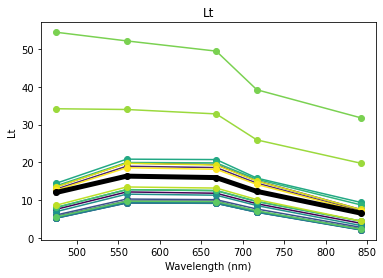

In [113]:
align_stack_tifs(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'), 
                 generateThumbnails=True, 
                 image_type='flight',
                 overwrite=True, 
                 out_format='Lt',
                 outputPath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Lt_stacks'),
                 DN_path = os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test', 'DN_flight_stacks'),
                 visualize=True)

Create stacked tifs of sky captures with units of radiance (Lsky)

True

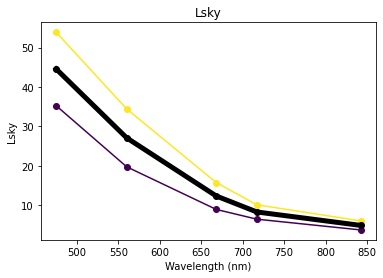

In [114]:
align_stack_tifs(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'), 
                 generateThumbnails=True, 
                 image_type='sky',
                 overwrite=True, 
                 out_format='Lsky',
                 outputPath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Lsky_stacks'),
                 DN_path = os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test', 'DN_sky_stacks'),
                 visualize=True)

### visualize_Ed

Downwelling irradiance (Ed) is needed to calculate reflectance (Ruas) and remote sensing reflectance (Rrs). Ed can be obtained three different ways:

1) 'DLS' : Ed is collected from the downwelling light sensor (DLS) with no correction

2) 'panel': Ed is calcualted from an image of the calibration reflectance panel

3) 'DLS_corr': DLS Ed is corrected using an image of the calibration reflectance panel 

This function calculated Ed using one of these options and plots Ed spectra 

In [43]:
def visualize_Ed(imagePath, Ed_opt, panel_ref_from_serial=""):
    flight_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'flight')).captures
    panel_imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, 'panel')).captures

    Ed_data = []
    Ed_columns = ['image', 'Ed_475', 'Ed_560', 'Ed_668', 'Ed_717', 'Ed_842']
    
    if Ed_opt == 'DLS':
        for i,capture in enumerate(flight_imgset):
            Ed = np.array(capture.dls_irradiance())*1000 #Scale to mW
            Ed[3], Ed[4] = Ed[4], Ed[3] #flip last two bands (red edge and NIR)
            Ed_row = ['capture_'+str(i+1)]+[np.mean(Ed[0])]+[np.mean(Ed[1])]+[np.mean(Ed[2])]+[np.mean(Ed[3])]+[np.mean(Ed[4])]
            Ed_data.append(Ed_row)
            
    if Ed_opt == 'panel':
        panels = np.array(panel_imgset)
        for i in range(len(panels)):               
            Ed = np.array(panels[i].panel_irradiance())*1000 #scale to mW
            Ed[3], Ed[4] = Ed[4], Ed[3] #flip last two bands (red edge and NIR)
            Ed_row = ['capture_'+str(i+1)]+[np.mean(Ed[0])]+[np.mean(Ed[1])]+[np.mean(Ed[2])]+[np.mean(Ed[3])]+[np.mean(Ed[4])]
            Ed_data.append(Ed_row)

    if Ed_opt == 'DLS_corr':
        panels = np.array(panel_imgset)
        panel_radiances = []
        for cap in panels:
            if cap.panels_in_all_expected_images():
                panel_radiances.append(cap.panel_radiance())
        panel_radiances = np.mean(np.asarray(panel_radiances)*1000, axis=0)
        panel_radiances[3], panel_radiances[4] = panel_radiances[4], panel_radiances[3] #flip last two bands

        #get mean irradiance from panel using known panel reflectance (from serial)
        irr_from_panel = math.pi * panel_radiances / panel_ref_from_serial       
        
        for i,capture in enumerate(flight_imgset):
            DLS_Ed = np.array(capture.dls_irradiance())*1000
            DLS_Ed[3], DLS_Ed[4] = DLS_Ed[4], DLS_Ed[3] #flip last two bands (red edge and NIR)
            dls_correction = irr_from_panel/DLS_Ed
            Ed = DLS_Ed*dls_correction
            Ed_row = ['capture_'+str(i+1)]+[np.mean(Ed[0])]+[np.mean(Ed[1])]+[np.mean(Ed[2])]+[np.mean(Ed[3])]+[np.mean(Ed[4])]
            Ed_data.append(Ed_row)
        
    Ed_data = pd.DataFrame.from_records(Ed_data, index='image', columns = Ed_columns)
    #TODO- add a 'save .csv' option?
    
    #plot Ed for every capture
    colors = plt.cm.viridis(np.linspace(0,1,len(Ed_data)))
    wv = [475, 560, 668, 717, 842]
    for i in range(len(Ed_data)):
        plt.plot(wv, Ed_data.iloc[i,0:5],  marker = 'o', color=colors[i])
        plt.title(Ed_opt + ' Ed')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Ed ($mW/m^2/nm$)') 
    

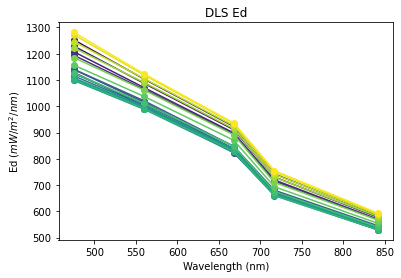

In [37]:
visualize_Ed(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'),
            Ed_opt='DLS')

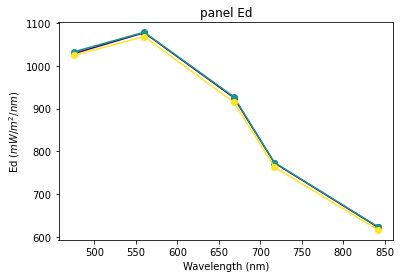

In [38]:
visualize_Ed(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'),
            Ed_opt='panel')

For 'Ed_opt = DLS_corr', you will need to know the reflectance values from the panel. You can find this by using the MicaSense Panel function which scans QR code from panel image

In [39]:
panel_ref_from_serial = []
for i in range(5):
    foo = panel.Panel(image.Image(os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test', 'panel', 'IMG_0001_'+ str(i+1) + '.tif'))). reflectance_from_panel_serial()
    panel_ref_from_serial.append(foo)
print(panel_ref_from_serial)

[0.5215, 0.5220666666666667, 0.5227866666666666, 0.5239466666666667, 0.5231133333333333]


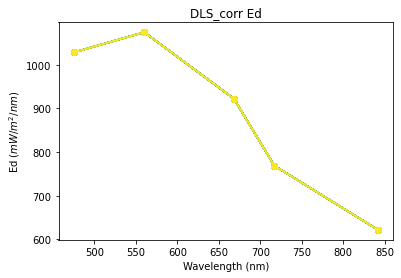

In [44]:
visualize_Ed(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'),
            Ed_opt='DLS_corr', panel_ref_from_serial=panel_ref_from_serial)

Create stacked tifs of flight captures with units of Ruas (Lt/Ed)

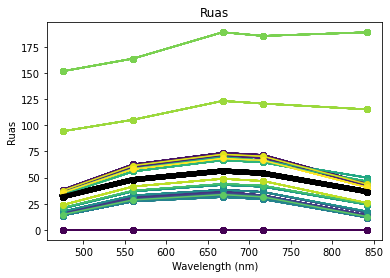

In [142]:
align_stack_tifs(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'),
                 image_type='flight',
                 out_format='Ruas',
                 outputPath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Ruas_stacks'),
                 overwrite=True, Ed_opt='DLS_corr',
                 panel_ref_from_serial=panel_ref_from_serial,
                 Lt_path = os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Lt_stacks'),
                 visualize=True)

Create stacked tifs of flight captures with units of Rrs (Lw/Ed) using the 'black_pixel' approach

In [143]:
align_stack_tifs(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'), 
                 generateThumbnails=True, 
                 image_type='flight',
                 overwrite=True, 
                 out_format='Rrs',
                 outputPath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Rrs_stacks_black_pixel'),
                 Ed_opt='DLS_corr',
                 panel_ref_from_serial=panel_ref_from_serial,
                 Rrs_method='black_pixel',
                 Lt_path = os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Lt_stacks'),
                 Lsky_path = os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Lsky_stacks'),
                 Ruas_path = os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Ruas_stacks'))

In [90]:
align_stack_tifs(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test'), 
                 generateThumbnails=True, 
                 image_type='flight',
                 overwrite=True, 
                 out_format='Rrs',
                 outputPath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Rrs_stacks_deglinting'),
                 Ed_opt='DLS_corr',
                 panel_ref_from_serial=panel_reflectance_from_serial,
                 Rrs_method='deglinting',
                 DN_flight_path = os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','DN_flight_stacks'),
                 Lt_path = os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Lt_stacks'),
                 Lsky_path = os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Lsky_stacks'),
                 Ruas_path = os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test','Ruas_stacks'))

True

Show examples of plotting individual images?

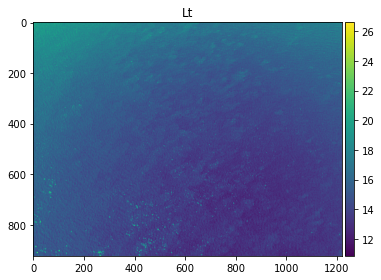

In [207]:
#Plot example Lt .tiff
#change Lt_16.tif to different number to plot another image
with rasterio.open(os.path.join(imagePath,'Lt_stacks','Lt_16.tif'), 'r') as src:
    Lt = src.read() 
    fig, axis = plotutils.plotwithcolorbar(Lt[0,:,:], title='Lt') #plotting blue band- change first index to plot diff band
    
#TODO- plot multiple images?    

## Test bed

In [168]:
def mask_pixels(imagePath, data_format, outputPath, upper_threshold=.014):
    
    imgset = imageset.ImageSet.from_directory(os.path.join(imagePath, data_format)).captures
    print('# of captures =', len(imgset))
    
'''    
    for i,capture in enumerate(imgset):
        outputFilename = out_format + '_'+ str(i+1) +'.tif' #+1 so naming starts at 1, not 0
        if os.path.exists(imagePath):
            with rasterio.open(os.path.join(imagePath, data_format+str(i+1)+'.tif')) as src:
                        profile = src.profile

                        all_dat = []
                        for j in range(1,6):
                            #calculate Ruas (Lt/Ed)
                            dat = src.read(j)
                            
                        stacked_Ruas = np.stack(Ruas_all) #stack into np.array

                        #write new stacked Ruas tif w/ reflectance units
                        with rasterio.open(os.path.join(outputPath, outputFilename), 'w', **profile) as dst:
                            dst.write(stacked_Ruas)
                else:
                    print("Lt stacked tifs must first be created")
    
   
    
    
    
    

                # open original flight_DN stacked tif
                if os.path.exists(DN_flight_path or DN_sky_path):
                    with rasterio.open(os.path.join(outputPath, out_format +'_'+ str(i+1) +'.tif'), 'r') as src:
                        profile = src.profile

                        profile.update(dtype=rasterio.float32) #change from unit16 to float32 ??

                        #write new stacked Lt tif w/ radiance units
                        with rasterio.open(os.path.join(outputPath, outputFilename), 'w', **profile) as dst:
                            dst.write(align)
                else:
                    print("DN stacked tifs must first be created")
'''                     

'    \n    for i,capture in enumerate(imgset):\n        outputFilename = out_format + \'_\'+ str(i+1) +\'.tif\' #+1 so naming starts at 1, not 0\n        if os.path.exists(imagePath):\n            with rasterio.open(os.path.join(imagePath, data_format+str(i+1)+\'.tif\')) as src:\n                        profile = src.profile\n\n                        all_dat = []\n                        for j in range(1,6):\n                            #calculate Ruas (Lt/Ed)\n                            dat = src.read(j)\n                            \n                        stacked_Ruas = np.stack(Ruas_all) #stack into np.array\n\n                        #write new stacked Ruas tif w/ reflectance units\n                        with rasterio.open(os.path.join(outputPath, outputFilename), \'w\', **profile) as dst:\n                            dst.write(stacked_Ruas)\n                else:\n                    print("Lt stacked tifs must first be created")\n    \n   \n    \n    \n    \n    \n\n       

In [ ]:
mask_pixels(imagePath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test', 'Rrs_black_pixel'),
              data_format='Rrs'
              upper_threshold=0.14,
              outputPath=os.path.join('F:/', 'Micasense_WQ', '10_01_20', '0002SET', '000_test', 'masked_Rrs_black_pixel')

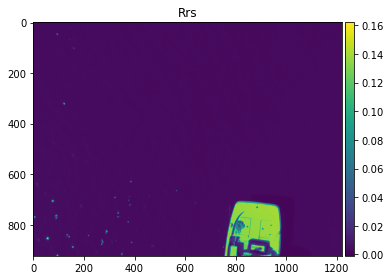

1.4901161e-08
(5, 923, 1219)


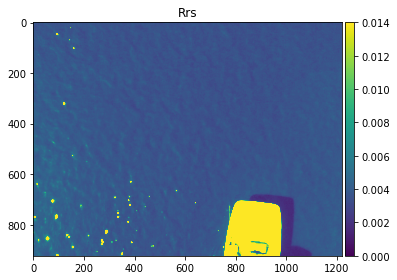

In [44]:
#Plot example Ruas .tiff
with rasterio.open(os.path.join(imagePath,'Rrs_blackpixel_stacks','Rrs_1.tif'), 'r') as src:
    Rrs = src.read() 
fig, axis = plotutils.plotwithcolorbar(Rrs[0,:,:], title='Rrs') #5th image
print(np.nanmax(Rrs[4,:,:]))
 
Rrs[4,:,:][Rrs[4,:,:]>0.01] = np.nan


nan_index = np.isnan(Rrs)
print(nan_index.shape)
for i in range(5):
    Rrs[i,:,:][nan_index[4,:,:]] = np.nan


fig, axis = plotutils.plotwithcolorbar(Rrs[0,:,:], title='Rrs', vmin=0, vmax=.014) #5th image



 if filter_pixels == True:
                    #+/- 2 sd from NIR median?
                    #or have user play around with thresholds?
                    align[4,:,:][align[4,:,:]>upper_NIR] = np.nan
                    align[4,:,:][align[4,:,:]<lower] = np.nan

    

### Apply Chl algorithms

### Georeference